### Import Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf                  
import tensorflow.nn as nn              
from tensorflow import keras 
from keras.models import Sequential
from keras.regularizers import L1L2
from keras.utils import to_categorical
from keras.initializers import lecun_uniform
from keras.optimizers import Adam
from keras.metrics import categorical_accuracy
from keras.layers import Input, Conv2D, ELU, BatchNormalization, MaxPool2D, MaxPooling2D, Reshape, Dense, CuDNNLSTM, LSTM, add, concatenate, Bidirectional, Dropout, TimeDistributed, Lambda, Permute, Flatten

2023-03-20 14:16:44.130143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Upload Data

In [44]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

### Shape of data

In [45]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


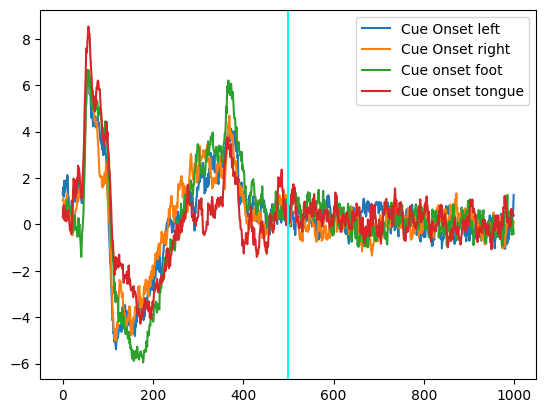

In [46]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [47]:
def data_prep(X,y,sub_sample,average,noise, period):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:period]
    #print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    #print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    #print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    #print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y

In [48]:
## Random splitting and reshaping the data

# generates the indices for splitting the data into training and validation sets

def data_finalize(period, total_number, takeout_sample,y_test = y_test):

    ind_valid = np.random.choice(total_number, takeout_sample, replace=False)
    ind_train = np.array(list(set(range(total_number)).difference(set(ind_valid))))

    # Creating the training and validation sets using the generated indices
    (X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
    (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


    # Preprocessing the dataset with a stride of 2 and padding of 2 on both sides
    x_train,y_train = data_prep(X_train,y_train,2,2,True, period)
    print('y_train:', y_train.shape)
    x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True, period)
    X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True, period)


    '''print('Shape of testing set:',X_test_prep.shape)
    print('Shape of testing labels:',y_test_prep.shape)

    print('Shape of training set:',x_train.shape)
    print('Shape of validation set:',x_valid.shape)
    print('Shape of training labels:',y_train.shape)
    print('Shape of validation labels:',y_valid.shape)'''



    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test_prep, 4)
    '''print('Shape of training labels after categorical conversion:',y_train.shape)
    print('Shape of validation labels after categorical conversion:',y_valid.shape)
    print('Shape of test labels after categorical conversion:',y_test.shape)'''

    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
    '''print('Shape of training set after adding width info:',x_train.shape)
    print('Shape of validation set after adding width info:',x_valid.shape)
    print('Shape of test set after adding width info:',x_test.shape) '''


    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)
    '''print('Shape of training set after dimension reshaping:',x_train.shape)
    print('Shape of validation set after dimension reshaping:',x_valid.shape)
    print('Shape of test set after dimension reshaping:',x_test.shape) '''
    
    return x_train, x_valid, x_test, y_train, y_valid, y_test

### CRNN Model

In [49]:
# Model parameters
# learning_rate = 0.001
# epsilon = 1e-8
# epochs = 50

# crnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate, epsilon = epsilon)

In [50]:
def CRNN_model(time_period):
    
    print("========== period:", time_period, " ==========")
    model = Sequential()
    
    model.add(Conv2D(16, kernel_size=(10,1), padding='same', activation='elu', input_shape=(time_period//2,1,22),use_bias = True, kernel_regularizer = L1L2(l1=0.0, l2=0.5)))
    model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # reduce the spatial dimensions (width and height) of feature maps
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(32, kernel_size=(10, 1), activation='elu', padding='same', use_bias = True, kernel_regularizer = L1L2(l1=0.0, l2=0.5)))
    model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv2D(64, kernel_size=(10, 1), activation='elu', padding='same', use_bias = True, kernel_regularizer = L1L2(l1=0.0, l2=0.5)))
    model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, kernel_size=(10, 1), activation='elu', padding='same', use_bias = True, kernel_regularizer = L1L2(l1=0.0, l2=0.5)))
    model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(TimeDistributed(Flatten()))

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=0.001, epsilon=1e-8, decay=0.01), metrics=['accuracy'])
    
    return model

## **Train the model on subject 1 data only and test it on subject 1 test set**

In [51]:
# prepping input for data_finalize
person_train_valid = person_train_valid.flatten()
X_train_valid=X_train_valid[np.where(person_train_valid==0)]
y_train_valid=y_train_valid[np.where(person_train_valid==0)]

In [52]:
x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=237, takeout_sample=42, period=1000, y_test=y_test)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
# get subject 1 data for test set
person_test=person_test.flatten()
X_test_sub1 = x_test[np.where(person_test==0)]
y_test_sub1 = y_test[np.where(person_test==0)]
print(X_test_sub1.shape)
print(y_test_sub1.shape)
model = CRNN_model(1000)
      
model.fit(x_train,
          y_train,
          batch_size=32,
          epochs=50,
          validation_data=(x_valid, y_valid), verbose=True)

train_score = model.evaluate(x_train, y_train)
test_score = model.evaluate(X_test_sub1, y_test_sub1)
print('train accuracy:', train_score[1]*100)
print('test accuracy:', test_score[1]*100)
# val_acc = basic_cnn_model_results.history['val_accuracy'][49]
# period_accuracy['subject1'] = val_acc
# print(period_accuracy)

y_train: (780,)
(780, 500, 1, 22)
(780, 4)
(168, 500, 1, 22)
(168, 4)
(50, 500, 1, 22)
(50, 4)
========== period: 1000  ==========
Epoch 1/50
25/25 [==============================] - 8s 100ms/step - loss: 54.5190 - accuracy: 0.2872 - val_loss: 30.8374 - val_accuracy: 0.3095
Epoch 2/50
25/25 [==============================] - 1s 32ms/step - loss: 21.1212 - accuracy: 0.3321 - val_loss: 13.7302 - val_accuracy: 0.3095
Epoch 3/50
25/25 [==============================] - 1s 30ms/step - loss: 10.3343 - accuracy: 0.4731 - val_loss: 8.2738 - val_accuracy: 0.3095
Epoch 4/50
25/25 [==============================] - 1s 30ms/step - loss: 6.4087 - accuracy: 0.5090 - val_loss: 5.9128 - val_accuracy: 0.3095
Epoch 5/50
25/25 [==============================] - 1s 31ms/step - loss: 4.5935 - accuracy: 0.5474 - val_loss: 4.7792 - val_accuracy: 0.3095
Epoch 6/50
25/25 [==============================] - 1s 29ms/step - loss: 3.4896 - accuracy: 0.6128 - val_loss: 4.4023 - val_accuracy: 0.3095
Epoch 7/50
25/25 

## **Train the model on all subject data and test it on subject 1 test set**


In [53]:
# reloading since we altered the input data for subject 
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [54]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [55]:
y_train_valid -= 769
y_test -= 769
print(y_train_valid.shape)
print(y_test.shape)
print(X_test_sub1.shape)
print(y_test_sub1.shape)

(2115,)
(443,)
(50, 500, 1, 22)
(50, 4)


In [56]:
x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=2115, takeout_sample=375, period=1000, y_test=y_test)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)
print(X_test_sub1.shape)
print(y_test_sub1.shape)
# X_test_sub1_2= x_test[np.where(person_test==0)]
# y_test_sub1_2 = y_test[np.where(person_test==0)]
model_2 = CRNN_model(1000)    
model_2.fit(x_train,
          y_train,
          batch_size=32,
          epochs=50,
          validation_data=(x_valid, y_valid), verbose=True)
# print(model_2.summary())
train_score = model_2.evaluate(x_train, y_train)
sub_test_score = model_2.evaluate(X_test_sub1, y_test_sub1)
all_test_score = model_2.evaluate(x_test, y_test)
print('train accuracy:', train_score[1]*100)
print('sub_test accuracy:', sub_test_score[1]*100)
print('all_test accuracy:', all_test_score[1]*100)

y_train: (6960,)
(6960, 500, 1, 22)
(6960, 4)
(1500, 500, 1, 22)
(1500, 4)
(1772, 500, 1, 22)
(1772, 4)
(50, 500, 1, 22)
(50, 4)
========== period: 1000  ==========
Epoch 1/50
218/218 [==============================] - 13s 38ms/step - loss: 12.1294 - accuracy: 0.2845 - val_loss: 2.1497 - val_accuracy: 0.2480
Epoch 2/50
218/218 [==============================] - 7s 32ms/step - loss: 1.7058 - accuracy: 0.3832 - val_loss: 1.8765 - val_accuracy: 0.2480
Epoch 3/50
218/218 [==============================] - 7s 32ms/step - loss: 1.4621 - accuracy: 0.4267 - val_loss: 1.4837 - val_accuracy: 0.3760
Epoch 4/50
218/218 [==============================] - 6s 29ms/step - loss: 1.3762 - accuracy: 0.4730 - val_loss: 1.3423 - val_accuracy: 0.4907
Epoch 5/50
218/218 [==============================] - 6s 29ms/step - loss: 1.3223 - accuracy: 0.4976 - val_loss: 1.3006 - val_accuracy: 0.4993
Epoch 6/50
218/218 [==============================] - 6s 30ms/step - loss: 1.2827 - accuracy: 0.5240 - val_loss: 1.262

## **Train data based on time periods**

In [57]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")
y_train_valid -= 769
y_test -= 769

In [58]:
print(y_train_valid.shape)
print(y_test.shape)

(2115,)
(443,)


In [60]:
def train_data(time_period, total_number, takeout_sample, y_test):
    # different period of time
    
    x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(time_period, total_number, takeout_sample, y_test)
    period_accuracy={}
    model = CRNN_model(time_period)
      
    crnn_model_results = model.fit(x_train,
              y_train,
              batch_size=32,
              epochs=50,
              validation_data=(x_valid, y_valid), verbose=True)
    # val_acc = crnn_model_results.history['val_accuracy'][49]
    #period_accuracy[str(time_period)] = val_acc
    train_score = model.evaluate(x_train, y_train)
    test_score = model.evaluate(x_test, y_test)
    print('train accuracy:', train_score[1]*100)
    print('test accuracy:', test_score[1]*100)
    
    return train_score,test_score


In [61]:
# For the time period between 50 and 500
short_time_train_scores = {}
short_time_test_scores = {}
for i in range (50, 550, 50):
    train_score, test_score = train_data(i,2115,375, y_test)
    short_time_train_scores[str(i)] = train_score[1]
    short_time_test_scores[str(i)] = test_score[1]
#     val_acc = crnn_model_results.history['val_accuracy'][49]
#     period_accuracy[str(i)] = val_acc
print('short_time_train_scores:',short_time_train_scores)
print('short_time_test_scores:',short_time_test_scores)

y_train: (6960,)
========== period: 50  ==========
Epoch 1/50
218/218 [==============================] - 10s 12ms/step - loss: 11.8929 - accuracy: 0.2730 - val_loss: 1.9190 - val_accuracy: 0.2240
Epoch 2/50
218/218 [==============================] - 2s 7ms/step - loss: 1.6118 - accuracy: 0.3312 - val_loss: 1.5208 - val_accuracy: 0.3093
Epoch 3/50
218/218 [==============================] - 2s 7ms/step - loss: 1.4435 - accuracy: 0.3463 - val_loss: 1.4281 - val_accuracy: 0.3327
Epoch 4/50
218/218 [==============================] - 2s 7ms/step - loss: 1.3933 - accuracy: 0.3583 - val_loss: 1.3939 - val_accuracy: 0.3533
Epoch 5/50
218/218 [==============================] - 2s 7ms/step - loss: 1.3741 - accuracy: 0.3647 - val_loss: 1.3874 - val_accuracy: 0.3393
Epoch 6/50
218/218 [==============================] - 2s 7ms/step - loss: 1.3618 - accuracy: 0.3697 - val_loss: 1.3647 - val_accuracy: 0.3580
Epoch 7/50
218/218 [==============================] - 2s 8ms/step - loss: 1.3481 - accuracy: 0

Epoch 6/50
218/218 [==============================] - 2s 8ms/step - loss: 1.3592 - accuracy: 0.4468 - val_loss: 1.3370 - val_accuracy: 0.4353
Epoch 7/50
218/218 [==============================] - 2s 8ms/step - loss: 1.3446 - accuracy: 0.4523 - val_loss: 1.3214 - val_accuracy: 0.4447
Epoch 8/50
218/218 [==============================] - 2s 8ms/step - loss: 1.3112 - accuracy: 0.4684 - val_loss: 1.2972 - val_accuracy: 0.4660
Epoch 9/50
218/218 [==============================] - 2s 8ms/step - loss: 1.2801 - accuracy: 0.4947 - val_loss: 1.2658 - val_accuracy: 0.4780
Epoch 10/50
218/218 [==============================] - 2s 8ms/step - loss: 1.2683 - accuracy: 0.4941 - val_loss: 1.2563 - val_accuracy: 0.4727
Epoch 11/50
218/218 [==============================] - 2s 8ms/step - loss: 1.2541 - accuracy: 0.4921 - val_loss: 1.2351 - val_accuracy: 0.4793
Epoch 12/50
218/218 [==============================] - 2s 8ms/step - loss: 1.2354 - accuracy: 0.5197 - val_loss: 1.2465 - val_accuracy: 0.4853
Epo

218/218 [==============================] - 2s 9ms/step - loss: 1.2404 - accuracy: 0.5329 - val_loss: 1.2675 - val_accuracy: 0.5120
Epoch 12/50
218/218 [==============================] - 2s 9ms/step - loss: 1.2162 - accuracy: 0.5457 - val_loss: 1.2571 - val_accuracy: 0.5233
Epoch 13/50
218/218 [==============================] - 2s 9ms/step - loss: 1.2017 - accuracy: 0.5474 - val_loss: 1.2414 - val_accuracy: 0.5247
Epoch 14/50
218/218 [==============================] - 2s 9ms/step - loss: 1.1789 - accuracy: 0.5622 - val_loss: 1.2321 - val_accuracy: 0.5540
Epoch 15/50
218/218 [==============================] - 2s 9ms/step - loss: 1.1689 - accuracy: 0.5710 - val_loss: 1.2221 - val_accuracy: 0.5313
Epoch 16/50
218/218 [==============================] - 2s 9ms/step - loss: 1.1504 - accuracy: 0.5759 - val_loss: 1.2377 - val_accuracy: 0.5120
Epoch 17/50
218/218 [==============================] - 2s 9ms/step - loss: 1.1577 - accuracy: 0.5746 - val_loss: 1.2012 - val_accuracy: 0.5413
Epoch 18/50

218/218 [==============================] - 2s 11ms/step - loss: 1.1361 - accuracy: 0.5830 - val_loss: 1.1639 - val_accuracy: 0.5553
Epoch 17/50
218/218 [==============================] - 2s 11ms/step - loss: 1.1238 - accuracy: 0.5861 - val_loss: 1.1090 - val_accuracy: 0.5793
Epoch 18/50
218/218 [==============================] - 3s 12ms/step - loss: 1.1066 - accuracy: 0.5951 - val_loss: 1.1224 - val_accuracy: 0.5847
Epoch 19/50
218/218 [==============================] - 3s 15ms/step - loss: 1.0928 - accuracy: 0.6065 - val_loss: 1.1117 - val_accuracy: 0.5807
Epoch 20/50
218/218 [==============================] - 2s 11ms/step - loss: 1.0790 - accuracy: 0.6102 - val_loss: 1.0952 - val_accuracy: 0.5933
Epoch 21/50
218/218 [==============================] - 2s 11ms/step - loss: 1.0662 - accuracy: 0.6228 - val_loss: 1.0824 - val_accuracy: 0.6067
Epoch 22/50
218/218 [==============================] - 2s 11ms/step - loss: 1.0487 - accuracy: 0.6293 - val_loss: 1.0857 - val_accuracy: 0.5987
Epoc

Epoch 21/50
218/218 [==============================] - 3s 13ms/step - loss: 1.0252 - accuracy: 0.6489 - val_loss: 1.1267 - val_accuracy: 0.5973
Epoch 22/50
218/218 [==============================] - 3s 12ms/step - loss: 1.0068 - accuracy: 0.6517 - val_loss: 1.1369 - val_accuracy: 0.5940
Epoch 23/50
218/218 [==============================] - 3s 12ms/step - loss: 0.9985 - accuracy: 0.6545 - val_loss: 1.1428 - val_accuracy: 0.5973
Epoch 24/50
218/218 [==============================] - 3s 12ms/step - loss: 0.9804 - accuracy: 0.6632 - val_loss: 1.1303 - val_accuracy: 0.6020
Epoch 25/50
218/218 [==============================] - 3s 12ms/step - loss: 0.9673 - accuracy: 0.6731 - val_loss: 1.1127 - val_accuracy: 0.6167
Epoch 26/50
218/218 [==============================] - 3s 12ms/step - loss: 0.9572 - accuracy: 0.6708 - val_loss: 1.1136 - val_accuracy: 0.6120
Epoch 27/50
218/218 [==============================] - 3s 12ms/step - loss: 0.9510 - accuracy: 0.6777 - val_loss: 1.1051 - val_accuracy:

Epoch 26/50
218/218 [==============================] - 3s 12ms/step - loss: 0.9067 - accuracy: 0.7139 - val_loss: 1.0312 - val_accuracy: 0.6487
Epoch 27/50
218/218 [==============================] - 3s 12ms/step - loss: 0.9000 - accuracy: 0.7093 - val_loss: 1.0374 - val_accuracy: 0.6540
Epoch 28/50
218/218 [==============================] - 3s 13ms/step - loss: 0.8837 - accuracy: 0.7145 - val_loss: 1.0281 - val_accuracy: 0.6553
Epoch 29/50
218/218 [==============================] - 3s 13ms/step - loss: 0.8788 - accuracy: 0.7168 - val_loss: 1.0250 - val_accuracy: 0.6387
Epoch 30/50
218/218 [==============================] - 3s 14ms/step - loss: 0.8847 - accuracy: 0.7190 - val_loss: 1.0325 - val_accuracy: 0.6320
Epoch 31/50
218/218 [==============================] - 3s 14ms/step - loss: 0.8654 - accuracy: 0.7218 - val_loss: 1.0144 - val_accuracy: 0.6393
Epoch 32/50
218/218 [==============================] - 3s 14ms/step - loss: 0.8759 - accuracy: 0.7135 - val_loss: 1.0139 - val_accuracy:

Epoch 31/50
218/218 [==============================] - 3s 15ms/step - loss: 0.8178 - accuracy: 0.7425 - val_loss: 1.0073 - val_accuracy: 0.6380
Epoch 32/50
218/218 [==============================] - 3s 15ms/step - loss: 0.8228 - accuracy: 0.7444 - val_loss: 1.0064 - val_accuracy: 0.6507
Epoch 33/50
218/218 [==============================] - 3s 15ms/step - loss: 0.8074 - accuracy: 0.7473 - val_loss: 1.0003 - val_accuracy: 0.6520
Epoch 34/50
218/218 [==============================] - 3s 16ms/step - loss: 0.7974 - accuracy: 0.7483 - val_loss: 1.0024 - val_accuracy: 0.6533
Epoch 35/50
218/218 [==============================] - 4s 16ms/step - loss: 0.7913 - accuracy: 0.7514 - val_loss: 0.9806 - val_accuracy: 0.6573
Epoch 36/50
218/218 [==============================] - 3s 15ms/step - loss: 0.8034 - accuracy: 0.7464 - val_loss: 0.9617 - val_accuracy: 0.6787
Epoch 37/50
218/218 [==============================] - 3s 15ms/step - loss: 0.7884 - accuracy: 0.7536 - val_loss: 0.9682 - val_accuracy:

Epoch 36/50
218/218 [==============================] - 3s 15ms/step - loss: 0.8008 - accuracy: 0.7497 - val_loss: 0.9380 - val_accuracy: 0.7213
Epoch 37/50
218/218 [==============================] - 3s 15ms/step - loss: 0.7919 - accuracy: 0.7532 - val_loss: 0.9155 - val_accuracy: 0.7187
Epoch 38/50
218/218 [==============================] - 3s 15ms/step - loss: 0.7721 - accuracy: 0.7549 - val_loss: 0.9332 - val_accuracy: 0.7107
Epoch 39/50
218/218 [==============================] - 3s 16ms/step - loss: 0.7724 - accuracy: 0.7591 - val_loss: 0.9140 - val_accuracy: 0.7233
Epoch 40/50
218/218 [==============================] - 3s 16ms/step - loss: 0.7729 - accuracy: 0.7601 - val_loss: 0.9236 - val_accuracy: 0.7167
Epoch 41/50
218/218 [==============================] - 3s 16ms/step - loss: 0.7561 - accuracy: 0.7652 - val_loss: 0.9178 - val_accuracy: 0.7127
Epoch 42/50
218/218 [==============================] - 4s 16ms/step - loss: 0.7611 - accuracy: 0.7612 - val_loss: 0.9015 - val_accuracy:

Epoch 41/50
218/218 [==============================] - 4s 16ms/step - loss: 0.7422 - accuracy: 0.7704 - val_loss: 0.9005 - val_accuracy: 0.7067
Epoch 42/50
218/218 [==============================] - 4s 20ms/step - loss: 0.7415 - accuracy: 0.7707 - val_loss: 0.9260 - val_accuracy: 0.7093
Epoch 43/50
218/218 [==============================] - 4s 19ms/step - loss: 0.7290 - accuracy: 0.7743 - val_loss: 0.9271 - val_accuracy: 0.7047
Epoch 44/50
218/218 [==============================] - 5s 22ms/step - loss: 0.7422 - accuracy: 0.7705 - val_loss: 0.8954 - val_accuracy: 0.7193
Epoch 45/50
218/218 [==============================] - 4s 18ms/step - loss: 0.7292 - accuracy: 0.7721 - val_loss: 0.8827 - val_accuracy: 0.7187
Epoch 46/50
218/218 [==============================] - 4s 16ms/step - loss: 0.7367 - accuracy: 0.7718 - val_loss: 0.8786 - val_accuracy: 0.7213
Epoch 47/50
218/218 [==============================] - 4s 16ms/step - loss: 0.7264 - accuracy: 0.7757 - val_loss: 0.9257 - val_accuracy:

Epoch 46/50
218/218 [==============================] - 4s 18ms/step - loss: 0.6918 - accuracy: 0.7853 - val_loss: 0.8617 - val_accuracy: 0.7047
Epoch 47/50
218/218 [==============================] - 4s 18ms/step - loss: 0.6920 - accuracy: 0.7874 - val_loss: 0.8488 - val_accuracy: 0.7093
Epoch 48/50
218/218 [==============================] - 4s 19ms/step - loss: 0.6792 - accuracy: 0.7928 - val_loss: 0.8623 - val_accuracy: 0.7120
Epoch 49/50
218/218 [==============================] - 5s 21ms/step - loss: 0.6931 - accuracy: 0.7882 - val_loss: 0.8583 - val_accuracy: 0.7100
Epoch 50/50
56/56 [==============================] - 0s 6ms/step - loss: 0.9522 - accuracy: 0.7037
train accuracy: 95.11494040489197
test accuracy: 70.37246227264404
short_time_train_scores: {'50': 0.5504310131072998, '100': 0.772988498210907, '150': 0.8291666507720947, '200': 0.8650861978530884, '250': 0.90675288438797, '300': 0.9316092133522034, '350': 0.9397988319396973, '400': 0.9419540166854858, '450': 0.94985634088

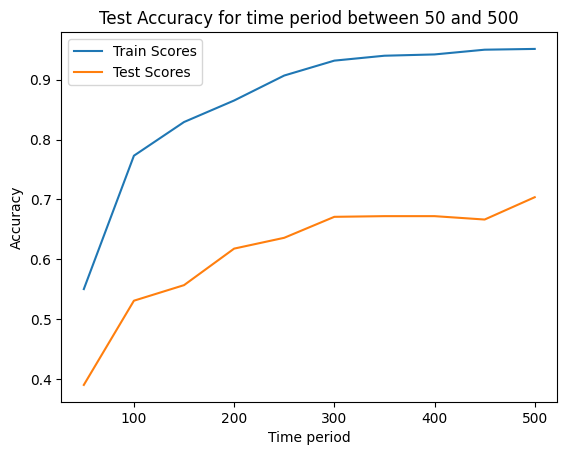

In [63]:
import matplotlib.pyplot as plt

# Create lists for x and y values
x_values = [int(k) for k in short_time_train_scores.keys()] # convert keys to integer values
train_scores = [v for v in short_time_train_scores.values()]
test_scores = [v for v in short_time_test_scores.values()]

# Plot the data
plt.plot(x_values, train_scores, label='Train Scores')
plt.plot(x_values, test_scores, label='Test Scores')

# Add labels and legend
plt.xlabel('Time period')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for time period between 50 and 500')
plt.legend()

# Show the plot
plt.show()

In [64]:
# for the time period between 600 and 1100
long_time_train_scores = {}
long_time_test_scores = {}

for j in range (600, 1100, 100):
    train_score, test_score = train_data(j,2115,375,y_test)
    long_time_train_scores[str(j)] = train_score[1]
    long_time_test_scores[str(j)] = test_score[1]
print('long_time_train_scores:',short_time_train_scores)
print('long_time_test_scores:',short_time_test_scores)

y_train: (6960,)
========== period: 600  ==========
Epoch 1/50
218/218 [==============================] - 17s 30ms/step - loss: 12.1607 - accuracy: 0.3083 - val_loss: 2.1908 - val_accuracy: 0.3007
Epoch 2/50
218/218 [==============================] - 5s 21ms/step - loss: 1.7150 - accuracy: 0.4193 - val_loss: 1.7347 - val_accuracy: 0.2713
Epoch 3/50
218/218 [==============================] - 4s 19ms/step - loss: 1.4681 - accuracy: 0.4580 - val_loss: 1.3975 - val_accuracy: 0.4700
Epoch 4/50
218/218 [==============================] - 4s 19ms/step - loss: 1.3877 - accuracy: 0.4795 - val_loss: 1.3056 - val_accuracy: 0.5140
Epoch 5/50
218/218 [==============================] - 4s 20ms/step - loss: 1.3416 - accuracy: 0.5020 - val_loss: 1.2640 - val_accuracy: 0.5313
Epoch 6/50
218/218 [==============================] - 5s 24ms/step - loss: 1.3059 - accuracy: 0.5119 - val_loss: 1.2284 - val_accuracy: 0.5227
Epoch 7/50
218/218 [==============================] - 6s 26ms/step - loss: 1.2600 - accu

218/218 [==============================] - 6s 26ms/step - loss: 1.3172 - accuracy: 0.4886 - val_loss: 1.2988 - val_accuracy: 0.5033
Epoch 6/50
218/218 [==============================] - 6s 27ms/step - loss: 1.2878 - accuracy: 0.5145 - val_loss: 1.2437 - val_accuracy: 0.5253
Epoch 7/50
218/218 [==============================] - 6s 26ms/step - loss: 1.2472 - accuracy: 0.5371 - val_loss: 1.2516 - val_accuracy: 0.5320
Epoch 8/50
218/218 [==============================] - 6s 25ms/step - loss: 1.2090 - accuracy: 0.5527 - val_loss: 1.1779 - val_accuracy: 0.5887
Epoch 9/50
218/218 [==============================] - 6s 27ms/step - loss: 1.1495 - accuracy: 0.5907 - val_loss: 1.0936 - val_accuracy: 0.6260
Epoch 10/50
218/218 [==============================] - 6s 28ms/step - loss: 1.1058 - accuracy: 0.6208 - val_loss: 1.0355 - val_accuracy: 0.6547
Epoch 11/50
218/218 [==============================] - 5s 25ms/step - loss: 1.0745 - accuracy: 0.6348 - val_loss: 1.0179 - val_accuracy: 0.6640
Epoch 12

218/218 [==============================] - 5s 24ms/step - loss: 1.1106 - accuracy: 0.6204 - val_loss: 1.1352 - val_accuracy: 0.5840
Epoch 11/50
218/218 [==============================] - 6s 28ms/step - loss: 1.0596 - accuracy: 0.6432 - val_loss: 1.0569 - val_accuracy: 0.6333
Epoch 12/50
218/218 [==============================] - 7s 31ms/step - loss: 1.0431 - accuracy: 0.6585 - val_loss: 1.0546 - val_accuracy: 0.6400
Epoch 13/50
218/218 [==============================] - 5s 25ms/step - loss: 1.0191 - accuracy: 0.6648 - val_loss: 1.0888 - val_accuracy: 0.5993
Epoch 14/50
218/218 [==============================] - 5s 23ms/step - loss: 0.9908 - accuracy: 0.6807 - val_loss: 1.0734 - val_accuracy: 0.6293
Epoch 15/50
218/218 [==============================] - 5s 24ms/step - loss: 0.9755 - accuracy: 0.6835 - val_loss: 1.0057 - val_accuracy: 0.6513
Epoch 16/50
218/218 [==============================] - 5s 24ms/step - loss: 0.9514 - accuracy: 0.6983 - val_loss: 1.0070 - val_accuracy: 0.6660
Epoc

Epoch 15/50
218/218 [==============================] - 7s 31ms/step - loss: 1.0304 - accuracy: 0.6516 - val_loss: 1.1084 - val_accuracy: 0.6107
Epoch 16/50
218/218 [==============================] - 7s 30ms/step - loss: 1.0008 - accuracy: 0.6638 - val_loss: 1.0919 - val_accuracy: 0.6240
Epoch 17/50
218/218 [==============================] - 7s 31ms/step - loss: 0.9858 - accuracy: 0.6747 - val_loss: 1.0352 - val_accuracy: 0.6480
Epoch 18/50
218/218 [==============================] - 7s 31ms/step - loss: 0.9499 - accuracy: 0.6940 - val_loss: 1.0450 - val_accuracy: 0.6493
Epoch 19/50
218/218 [==============================] - 7s 30ms/step - loss: 0.9184 - accuracy: 0.7096 - val_loss: 1.0293 - val_accuracy: 0.6627
Epoch 20/50
218/218 [==============================] - 6s 29ms/step - loss: 0.9127 - accuracy: 0.7037 - val_loss: 1.0122 - val_accuracy: 0.6853
Epoch 21/50
218/218 [==============================] - 6s 29ms/step - loss: 0.8863 - accuracy: 0.7168 - val_loss: 1.0045 - val_accuracy:

Epoch 20/50
218/218 [==============================] - 7s 30ms/step - loss: 0.8972 - accuracy: 0.7102 - val_loss: 1.0731 - val_accuracy: 0.6440
Epoch 21/50
218/218 [==============================] - 6s 29ms/step - loss: 0.8610 - accuracy: 0.7282 - val_loss: 1.0686 - val_accuracy: 0.6540
Epoch 22/50
218/218 [==============================] - 6s 29ms/step - loss: 0.8565 - accuracy: 0.7286 - val_loss: 1.0624 - val_accuracy: 0.6747
Epoch 23/50
218/218 [==============================] - 6s 29ms/step - loss: 0.8382 - accuracy: 0.7392 - val_loss: 1.0446 - val_accuracy: 0.6793
Epoch 24/50
218/218 [==============================] - 6s 29ms/step - loss: 0.8366 - accuracy: 0.7352 - val_loss: 1.0612 - val_accuracy: 0.6787
Epoch 25/50
218/218 [==============================] - 7s 32ms/step - loss: 0.8066 - accuracy: 0.7529 - val_loss: 1.0590 - val_accuracy: 0.6473
Epoch 26/50
218/218 [==============================] - 7s 31ms/step - loss: 0.7966 - accuracy: 0.7493 - val_loss: 1.0718 - val_accuracy:

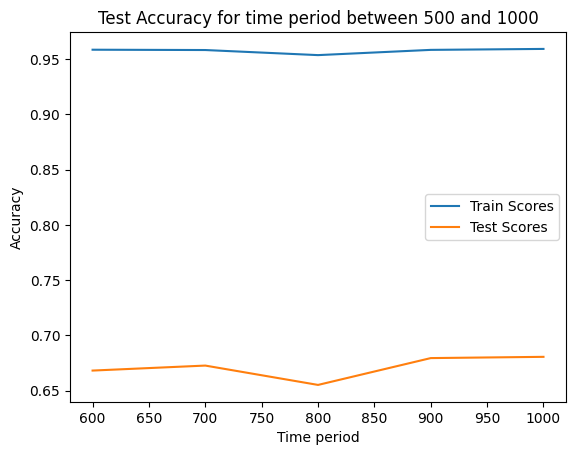

In [65]:
# Create lists for x and y values
x_values = [int(k) for k in long_time_train_scores.keys()] # convert keys to integer values
train_scores = [v for v in long_time_train_scores.values()]
test_scores = [v for v in long_time_test_scores.values()]

# Plot the data
plt.plot(x_values, train_scores, label='Train Scores')
plt.plot(x_values, test_scores, label='Test Scores')

# Add labels and legend
plt.xlabel('Time period')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for time period between 500 and 1000')
plt.legend()

# Show the plot
plt.show()